In [1]:
import sqlite3, json
import pandas as pd
import subprocess as spc
import dateparser

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# #export CC databases
# spc.run("curl 'https://craftcollectivedist.com/ECP_19.12_A/aspx1/Home.aspx?ParseFromReportURL=True&ReportID=5062127&ReportName=CUSTOMERS_XLSX' -H 'authority: craftcollectivedist.com' -H 'upgrade-insecure-requests: 1' -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' -H 'sec-fetch-site: same-origin' -H 'sec-fetch-mode: navigate' -H 'referer: https://craftcollectivedist.com/ECP_19.12_A/aspx1/SavedReports.aspx?' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9' -H 'cookie: EncompassDistributor=CraftCollect; EncompassDBServer=MySQL12; EncompassSessionID=17bbb91f5e21b866fe9b853c0faf3bfc; EncompassGuestDashboardID=147731; Email=ben@fab.beer; MenuCollapsed=False; ExpireTime=1578200455484' --compressed > customers.xslx",
#                         shell=True, stdout=spc.PIPE)
# spc.run("curl 'https://craftcollectivedist.com/ECP_19.12_A/aspx1/Home.aspx?ParseFromReportURL=True&ReportID=5062129&ReportName=CUSTOMER_HISTORY_XSLX' -H 'authority: craftcollectivedist.com' -H 'upgrade-insecure-requests: 1' -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' -H 'sec-fetch-site: same-origin' -H 'sec-fetch-mode: navigate' -H 'referer: https://craftcollectivedist.com/ECP_19.12_A/aspx1/SavedReports.aspx?' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9' -H 'cookie: EncompassDistributor=CraftCollect; EncompassDBServer=MySQL12; EncompassSessionID=17bbb91f5e21b866fe9b853c0faf3bfc; EncompassGuestDashboardID=147731; Email=ben@fab.beer; MenuCollapsed=False; ExpireTime=1578200455484' --compressed > customer_history.xslx",
#                         shell=True, stdout=spc.PIPE)

# #generate PD dataframes
# CUSTOMERS_DF = pd.read_excel("customers.xslx")
# CUSTOMER_HISTORY_DF = pd.read_excel("customer_history.xslx")

In [3]:
#IMPORT UNTAPPD DATAFRAME
conn = sqlite3.connect("untappd.db")
df = pd.read_sql_query("select * from checkins;", conn)
jsons  = df.json.apply(lambda j: json.loads(j))
CHECKINS_DF = pd.DataFrame(jsons.apply(lambda x: pd.Series(x)))


In [4]:
def expand(df, key):
    return df.apply(lambda x:pd.concat([x,pd.Series(list(x[key].values()),index=[(f"{key}_{k}" if not key in k else k ) for k in list(x[key].keys())]) if type(x[key])==dict else None]) , axis = 1).drop(key,axis="columns")#.filter(regex=f"^((?!{key}).)*$", axis="columns")

expanded = expand(expand(expand(expand(CHECKINS_DF,"venue"),"beer"),"brewery"),"venue_location")

In [5]:
len(CHECKINS_DF)

126

In [6]:
expanded.created_at

0      Sat, 07 Dec 2019 16:14:56 +0000
1      Wed, 11 Dec 2019 21:29:28 +0000
2      Fri, 20 Dec 2019 19:54:12 +0000
3      Fri, 20 Dec 2019 19:59:07 +0000
4      Sun, 22 Dec 2019 16:46:00 +0000
                    ...               
121    Tue, 07 Jan 2020 00:33:22 +0000
122    Tue, 07 Jan 2020 00:35:13 +0000
123    Tue, 07 Jan 2020 03:06:46 +0000
124    Tue, 07 Jan 2020 03:08:58 +0000
125    Tue, 07 Jan 2020 13:25:12 +0000
Name: created_at, Length: 126, dtype: object

In [7]:
expanded["created_date"] = expanded.created_at.apply(lambda x: dateparser.parse(x))

expanded["created_day"] = expanded["created_date"].apply(lambda x: x.timestamp()/3600//24)
expanded["created_week"] = expanded["created_date"].apply(lambda x: x.timestamp()/3600/24//7)
with_ratings = expanded.loc[expanded.rating_score > 0]

In [8]:
%matplotlib inline

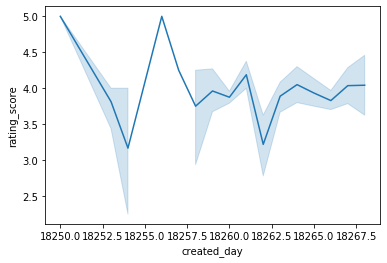

In [13]:
sns.lineplot(x = "created_day", y="rating_score", data = with_ratings)

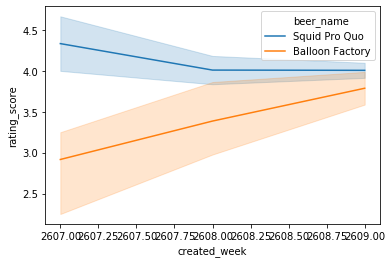

In [10]:
sns.lineplot(x = "created_week", y="rating_score", hue = "beer_name", data = with_ratings)

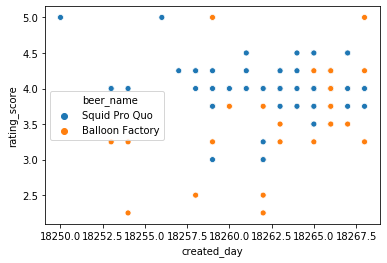

In [11]:
sns.scatterplot(x = "created_day", y="rating_score",hue="beer_name", data = with_ratings)